#  Computational experiment with the reduced number of classifiers

The Event Related Potential (ERP) starts in the stimulus onset of and lasts 1200 ms. The data include EEG recorded from 128 channels BioSemi headcap at 256 Hz sampling rate.
The quality criterion is accuracy and AUC on the cross-validated data.
Models: 
1. Gaussian process classification
2. Bayesian naive classification
3. Logistic regression

The features are generated by the First Principal Components of extended covariance matrix. The covariance is between pairs of electrodes’ time series. 

This notebook contains three sections 1) plot AUC of the selected models and users, 2) table the accuracy of each user, 3) exhaustive classification model comparison.

Caveat: This dataset has relatively few trials per subject since the study analyzed several other experimental conditions not of interest here. The data set contains about 80 events per participant x 13 participants vs 128ch x 450 time points comprising the EEG response. It contains events with noisy redundant signals that could be classified concerning the user’s responses. Each user has a unique pattern of brain signals, which creates obstacles to merging them into one common dataset. We aim to augment these data and mitigate the data heterogeneity issue (e.g., using standardization) to aid model performance.

**WARNING! The results (AUCs, accuracy) below could be overtrained and unstable due to insuffitient sample size and redundant features.**

In [58]:
%%capture
%matplotlib inline
!pip3 install mne
!pip3 install pyriemann

In [59]:
import numpy as np
#--- 
import pandas as pd
import scipy.io as sio # Download mat files
from google.colab import drive # Mount the drive
from google.colab import files # Save the experimental results to the drive 
#---
import mne # MNE and PyRiemann are tha main tools for classification
from mne import io
from mne.datasets import sample
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
#---
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
#---
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, ExpSineSquared, DotProduct
#---
from sklearn.metrics import RocCurveDisplay # Plot the ROC 
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [60]:
# Three models selected and sorted. They return probabilistic values of classes
names = [
    "Logistic Regression",
    "Gaussian Process",
    "Naive Bayes",    
    ]
classifiers = [
    LogisticRegression(),
    GaussianProcessClassifier(1.0 * RBF(1.0)), 
    GaussianNB(),
    ]

In [61]:
# Exhaustive set of alternative models to compare
# Zip names and classifiers to run the experiment
names_all = [
    "Logistic Regression",
    "Gaussian Process",
    "GP matern",
    "GP quad",
    "GP linear",
    #"GP period",    
    "Linear SVM",
    "RBF SVM",
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    ]
classifiers_all = [
    LogisticRegression(),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    GaussianProcessClassifier(kernel=Matern(length_scale=1.0, nu=1.5)),
    GaussianProcessClassifier(kernel=RationalQuadratic(length_scale=1.0, alpha=1.0, alpha_bounds=(1e-5, 1e5))),
    GaussianProcessClassifier(kernel=DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e5))),
    #GaussianProcessClassifier(kernel=ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds=(1e-5, 1e5))),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
  ]
print(f'There are {len(classifiers_all)} alternative models to compare')

There are 14 alternative models to compare


This cell loads the dataset from Google Drive. It requests access to the 'content/drive/[yours]' folder. The mat-file with data should be downloaded to the designated, see below, folder to Google Drive. The file format is described in the m-file step1_.m that created the data. 

In [111]:
# The data files are in the drive
drive.mount('/content/drive')
# Load data
#%cd '/content/drive/MyDrive/EEG/DataApr28/'
#fnames = ['EEG_Recog_elAll_800ms_Apr28.mat','UMN_Recog_elAll_800ms_Apr28.mat',]
%cd  '/content/drive/MyDrive/EEG/DataApr26/'
%ls
mat_fname = 'EEG_epoch_only3responses_corr.mat'
mat_contents = sio.loadmat(mat_fname)
dataX = mat_contents['dataX']                   # The design matrix Events x Electrodes x Time
dataY = np.squeeze(mat_contents['dataY'])       # The target matrix has columns: 
# Predefined indexes of columns in the dataY structure, see the Matlab part 
USER_ = 0  # The first column of dataY is the username
EVENT_ = 1 # The second in the Event, concentrate on 180 and 200 (Old versus New word)
RESP_ = 2  # The third is the response 1, 2 and 11, 12 (Incorrect versus Correct)
# List of all available users in the data
users = np.array([1158,1045,7980,1037,6639,1363,7977,7974,2038,1327,1368,1385,1034])
# Event codes as classes Old word versus New word in the Recognition task
#classes = np.array([[140, 145], [150, 160], [180, 200], [150, 170], [160, 170]])
cls = [180, 200] 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EEG/DataApr26
Accuracy_sliding_window.xlsx       Model_comparison.xlsx
EEG_epoch_only3responses_corr.mat  Res180_vs_200.xlsx


## Section 1. Plot AUC of the selected models and users

Plot AUC on the reduced number of classifiers. Select three of the most promising. Also, reduce the number of users to the first few with the highest accuracy. Join them to augment the sample size.


Figure 1. Classification ROC for six users of the highest accuracy under condition (a) given only “Correct” responses to the stimulus “Old word” or “New word”, other responses are dropped.

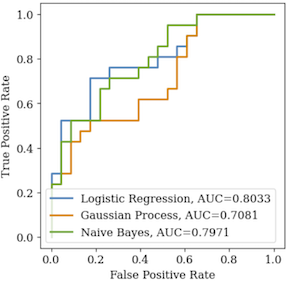

In [112]:
# Prepare the design matrix and target vector 
# Select users
userselect = np.array([1158,1045,7980,1037,6639,1363]) # Six users with higher accuracy
idxCls1 = np.array([]); # Indexes of the selected subset. Class 1.
idxCls2 = np.array([]); # Class 2.

for usersel in userselect: # Join selected users in one dataset to augment sample size
  idx1 = np.where((dataY[:,EVENT_] == cls[0]) & (dataY[:,USER_] == usersel) & \
                  (dataY[:,RESP_] > 2))     # Only correct responses
  idx2 = np.where((dataY[:,EVENT_] == cls[1]) & (dataY[:,USER_] == usersel) & \
                  (dataY[:,RESP_] > 2))     # ditto
  idxCls1 = np.append(idxCls1, idx1, axis=None)
  idxCls2 = np.append(idxCls2, idx2, axis=None)
# end for 

idxCls12 = np.append(idxCls1, idxCls2, axis=None).astype(int) # Two classes
#print(idxCls12)
X12 = np.squeeze(dataX[idxCls12,:,:]) 
Y1 = np.zeros(len(idxCls1)) 
Y2 = np.ones(len(idxCls2)) 
Y12 = np.append(Y1, Y2)
print(f'Users: {userselect} --- Events: {cls} --- Data shape: {X12.shape} --- Class balance: {np.size(idxCls1)} vs {np.size(idxCls2)}')
# Run 
#acc = run_classifier(X1,Y1)
#print("Classification accuracy: %f " % (acc))  
X = X12
Y = Y12

Users: [1158 1045 7980 1037 6639 1363] --- Events: [180, 200] --- Data shape: (444, 128, 410) --- Class balance: 225 vs 219


Run for three selected classifiers

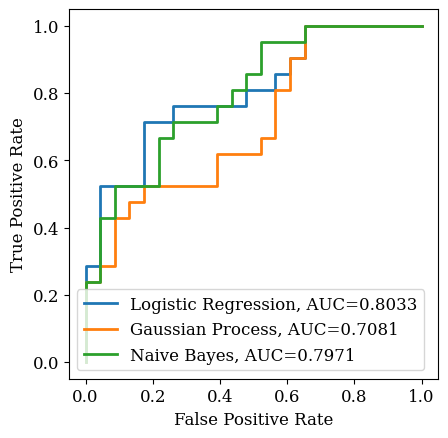

In [113]:
n_components = 5  # pick some components
for name, clf in zip(names, classifiers):
  clf = make_pipeline(
      XdawnCovariances(n_components),
      TangentSpace(metric="riemann"),   
      clf, #LogisticRegression(),
      )
  cv = KFold(n_splits=10, shuffle=True, random_state=42)
  for train_idx, test_idx in cv.split(X): 
    preds = np.zeros(len(Y))
    y_train, y_test = Y[train_idx], Y[test_idx]
    clf.fit(X[train_idx], y_train)
    #preds[test_idx] = clf.predict(X[test_idx]) # Binary for accuracy
    preds[test_idx] = clf.predict_proba(X[test_idx])[::,1] # Probabilty for AUC
  fpr, tpr, _ = metrics.roc_curve(Y[test_idx], preds[test_idx])
  auc = round(metrics.roc_auc_score(Y[test_idx], preds[test_idx]), 4)
  plt.plot(fpr,tpr,label=name+", AUC="+str(auc))
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
#plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 12#24
plt.rcParams['ytick.labelsize'] = 12#24
plt.rcParams['legend.fontsize'] = 12#24
#plt.rcParams['axes.titlesize'] = 36. 
plt.rcParams['axes.labelsize'] = 12#24
plt.gca().set_aspect('equal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

##  The accuracy of each user for three selected models


Subexperiment 1 
Consequently add the most prominent users and keep training the mode.
Join the previous two cells to consequently append the users.
Do not change this code, it is fixed.

## Exhaustive classification model comparison

See description in the previous report


Table 1. Classification accuracy per user (Recognition, the cases with incorrect answers dropped out). 

Table 2 shows the list of ordered users. Six users were selected for grouping: 1158, 1045, 7980, 1037, 6639, and 1363. We join users with the highest accuracy to avoid instant overtraining. We may need additional alignment to make a group (signal amplitude and peak dynamic time warping). After the user joins, the model trains the whole group with reduced accuracy and is tested on each user separately. 

Table 2 collects the results from the computational experiment on Apr 26th. Three basic models were selected according to the obtained accuracy, The Logistic regression model as the simplest one, the Naive Bayesian classification model as the generalization of the LR, and the Gaussian process classification model as the generalization of these two. The deterministic part of these models is the linear combination of features. Further, we will investigate classes of Space-State models under the plausibility of Gaussian processes models.



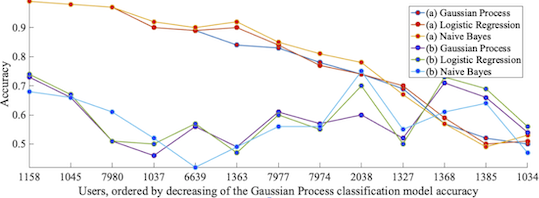

1. Learn and test three selected models for each available user
2. Lean and text all alternative models for each available user

In [100]:
tabAUC  = np.zeros([0,2]) # Table for results, users times models for one class 
for usr in users:
  idx1 = np.where((dataY[:,EVENT_] == cls[0]) & (dataY[:,USER_] == usr)) #& \
                  #(dataY[:,RESP_] > 2))     # Only correct responses
  idx2 = np.where((dataY[:,EVENT_] == cls[1]) & (dataY[:,USER_] == usr)) #& \
                  #(dataY[:,RESP_] > 2))     # ditto
                  # Comment two RESP_ lines above to include all events regardless of responses
  idx12 = np.append(idx1, idx2, axis=None).astype(int)
  X = np.squeeze(dataX[idx12,:,:])
  Y1 = np.zeros(len(idx1[0])) 
  Y2 = np.ones(len(idx2[0])) 
  Y = np.append(Y1, Y2)
  print(f'User: {usr}, class {cls},  balance {np.size(idx1)} vs {np.size(idx2)}, shape {X.shape}')
  for name, clf in zip(names, classifiers):
    clf = make_pipeline(
      XdawnCovariances(n_components),
      TangentSpace(metric="riemann"),   
      clf, #LogisticRegression(),
      )
    for train_idx, test_idx in cv.split(X): 
      preds = np.zeros(len(Y))
      y_train, y_test = Y[train_idx], Y[test_idx]
      clf.fit(X[train_idx], y_train)
      # preds[test_idx] = clf.predict(X[test_idx]) # Binary for accuracy
      preds[test_idx] = clf.predict_proba(X[test_idx])[::,1] # Probabilty for AUC    
      fpr, tpr, _ = metrics.roc_curve(Y[test_idx], preds[test_idx])
      auc = round(metrics.roc_auc_score(Y[test_idx], preds[test_idx]), 4)
      print(f'Model: {name}, AUC = {auc}, accuracy = acc')
      tabAUC = np.vstack((tabAUC, [usr, auc]))
    # end for models
# end for users  

# Save the DataFrame to an Excel file and download to the local folder
df = pd.DataFrame(tabAUC)
fname = f'Model_comparison.xlsx'
df.to_excel(fname, index=False) 
files.download(fname)

User: 1158, class [180, 200],  balance 44 vs 39, shape (83, 128, 410)


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Logistic Regression, AUC = 1.0, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Logistic Regression, AUC = 0.8889, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Logistic Regression, AUC = 0.8, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Logistic Regression, AUC = 0.6667, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Gaussian Process, AUC = 1.0, accuracy = acc
Model: Gaussian Process, AUC = 1.0, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')
/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Gaussian Process, AUC = 1.0, accuracy = acc
Model: Gaussian Process, AUC = 1.0, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Gaussian Process, AUC = 1.0, accuracy = acc
Model: Gaussian Process, AUC = 1.0, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Gaussian Process, AUC = 0.7333, accuracy = acc
Model: Gaussian Process, AUC = 1.0, accuracy = acc
Model: Gaussian Process, AUC = 1.0, accuracy = acc
Model: Gaussian Process, AUC = 1.0, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Naive Bayes, AUC = 1.0, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Naive Bayes, AUC = 0.8333, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Naive Bayes, AUC = 1.0, accuracy = acc
Model: Naive Bayes, AUC = 1.0, accuracy = acc
Model: Naive Bayes, AUC = 0.6667, accuracy = acc
Model: Naive Bayes, AUC = 1.0, accuracy = acc


/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')
/usr/local/lib/python3.10/dist-packages/pyriemann/utils/mean.py:470: UserWarning: Convergence not reached
  warnings.warn('Convergence not reached')


Model: Naive Bayes, AUC = 0.8, accuracy = acc
Model: Naive Bayes, AUC = 1.0, accuracy = acc
Model: Naive Bayes, AUC = 1.0, accuracy = acc
Model: Naive Bayes, AUC = 1.0, accuracy = acc
User: 1045, class [180, 200],  balance 40 vs 39, shape (79, 128, 410)
Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Logistic Regression, AUC = 0.6667, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Logistic Regression, AUC = 1.0, accuracy = acc
Model: Gaussian Process, AUC = 1.0, accuracy = acc
Model: Gaussian Process, AUC = 1.0, accuracy = acc
Model: Gaussian Process, AUC = 1.0, accuracy = acc
Model: Gaussian Process, AUC = 0.6667, accuracy = 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ValueError: ignored

In [76]:
print(Y)

[0. 1.]


In [82]:

print
# Concatenate the vectors
concatenated = np.concatenate((np.ones(5), np.zeros(6)))
print(concatenated)

[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


In [91]:
len(idx2)

1

In [96]:
# Create a numpy array
arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 9])

# Find the indices where the array elements are greater than 3
indices = np.where(arr > 3)

# Get the length of the tuple returned by np.where()
length = len(indices[0])

print(length)  # Output: 1
print(indices)

7
(array([3, 4, 5, 6, 7, 8, 9]),)
